# Scalable GP Regression in 1D (w/ KISS-GP)

## Introduction

For 1D functions, SKI (or KISS-GP) is a great way to scale a GP up to very large datasets (100,000+ data points).
Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

SKI is asymptotically very fast (nearly linear), very precise (error decays cubically), and easy to use in GPyTorch!
As you will see in this tutorial, it's really easy to apply SKI to an existing model. All you have to do is wrap your kernel module with a `GridInterpolationKernel`.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

### Set up training data

We'll learn a simple sinusoid, but with lots of training data points. At 1000 points, this is where scalable methods start to become useful.

In [2]:
train_x = torch.linspace(0, 1, 1000)
train_y = torch.sin(train_x * (4 * math.pi) + torch.randn(train_x.size()) * 0.2)

## Set up the model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](./Simple_GP_Regression.ipynb).

The only difference: we're wrapping our kernel module in a `GridInterpolationKernel`. This signals to GPyTorch that you want to approximate this kernel matrix with SKI.

SKI has only one hyperparameter that you need to worry about: the grid size. For 1D functions, a good starting place is to use as many grid points as training points. (Don't worry - the grid points are really cheap to use!). You can use the `gpytorch.utils.grid.choose_grid_size` helper to get a good starting point.

If you want, you can also explicitly determine the grid bounds of the SKI approximation using the `grid_bounds` argument. However, it's easier if you don't use this argument - then GPyTorch automatically chooses the best bounds for you.

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.RBFKernel(), grid_size=grid_size, num_dims=1,
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

## Train the model hyperparameters

Even with 1000 points, this model still trains fast! SKI scales (essentially) linearly with data - whereas standard GP inference scales quadratically (in GPyTorch.)

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 30
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/30 - Loss: 1.137
Iter 2/30 - Loss: 1.109
Iter 3/30 - Loss: 1.081
Iter 4/30 - Loss: 1.053
Iter 5/30 - Loss: 1.025
Iter 6/30 - Loss: 0.996
Iter 7/30 - Loss: 0.966
Iter 8/30 - Loss: 0.935
Iter 9/30 - Loss: 0.903
Iter 10/30 - Loss: 0.866
Iter 11/30 - Loss: 0.815
Iter 12/30 - Loss: 0.738
Iter 13/30 - Loss: 0.632
Iter 14/30 - Loss: 0.511
Iter 15/30 - Loss: 0.396
Iter 16/30 - Loss: 0.305
Iter 17/30 - Loss: 0.233
Iter 18/30 - Loss: 0.173
Iter 19/30 - Loss: 0.121
Iter 20/30 - Loss: 0.073
Iter 21/30 - Loss: 0.023
Iter 22/30 - Loss: -0.024
Iter 23/30 - Loss: -0.070
Iter 24/30 - Loss: -0.115
Iter 25/30 - Loss: -0.158
Iter 26/30 - Loss: -0.204
Iter 27/30 - Loss: -0.239
Iter 28/30 - Loss: -0.279
Iter 29/30 - Loss: -0.313
Iter 30/30 - Loss: -0.343


# Make predictions

SKI is especially well-suited for predictions. It can comnpute predictive means in constant time, and with LOVE enabled (see [this notebook](../05_Scalable_GP_Regression_Multidimensional/KISSGP_Deep_Kernel_Regression_With_LOVE_Fast_Variances_CUDA.ipynb)), predictive variances are also constant time.

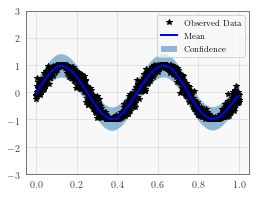

In [5]:
# Put model & likelihood into eval mode
model.eval()
likelihood.eval()

# Initalize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))

# The gpytorch.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    prediction = likelihood(model(test_x))
    mean = prediction.mean
    # Get lower and upper predictive bounds
    lower, upper = prediction.confidence_region()

# Plot the training data as black stars
ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
# Plot predictive means as blue line
ax.plot(test_x.detach().numpy(), mean.detach().numpy(), 'b')
# Plot confidence bounds as lightly shaded region
ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

None